In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

from common import loss_utils

import sys
sys.path.append('./dgmr-mod')
import dgmr

/home/sigaida/miniconda3/envs/chtest-newest/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [7]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # can shift up/down by 128*0.1 = 12.8 pixels
])

In [8]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
#         -1 means rotate cw 90, 0 means no rotation, 1 means ccw 90, 2 means ccw 180
        rot_amount = self.generator.randint(-1, 3)
        if rot_amount != 0:
            all_data = np.rot90(all_data, k=rot_amount, axes=(1, 2)).copy()
#         generate contrast and brightness changes
        cf = np.random.uniform(low=0.7, high=1.3)
        bf = np.random.uniform(low=-50, high=50)
        all_data = all_data * cf + bf
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2,
    prefetch_factor=4
)


In [9]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

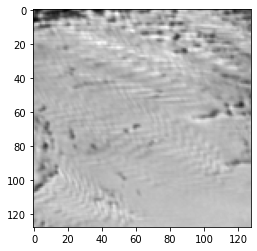

In [11]:
plt.imshow(x[-1], cmap='gray')

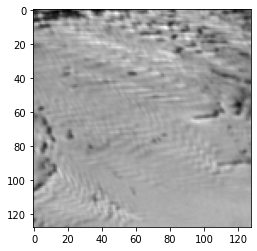

In [12]:
plt.imshow(y[0], cmap='gray')

In [13]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=96, # 96
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(4 * 1, 128 // 32, 128 // 32),
    output_channels=192, # 192
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=192, # 192
    context_channels=96, # 96
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
model = model.to(DEVICE)


# model = dgmr.DGMR(
#     forecast_steps=FORECAST,
#     input_channels=1,
#     output_shape=128,
#     latent_channels=384,
#     context_channels=192,
#     num_samples=3,
# )
# model.load_state_dict(torch.load('weights/300d_dgmr/dgmr_epochs=24_loss=0.0412.pt'))
# model = model.to(DEVICE)


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 3353443 trainable parameters


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# msssim_criterion = loss_utils.MS_SSIMLoss(1.0, channels=24)
msssim_criterion = loss_utils.MS_SSIMLoss(1023.0, channels=24)


In [16]:
# def handle_back_nan_hook(self, grad_input, grad_output):
#     if isinstance(grad_output, tuple):
#         return tuple(torch.nan_to_num(go, nan=0.0, posinf=1.0, neginf=-1.0) for go in grad_output)
#     else:
#         return torch.nan_to_num(grad_output, nan=0.0, posinf=1.0, neginf=-1.0)

# for submodule in model.modules():
#     submodule.register_backward_hook(handle_back_nan_hook)

def handle_back_nan_hook(grad):
    # stop nans, inf, -inf, and large values in general
    grad = torch.nan_to_num(grad, nan=0.0, posinf=1.0, neginf=-1.0)
    grad = torch.clip(grad, min=-1.0, max=1.0)
    return grad

for p in model.parameters():
    p.register_hook(handle_back_nan_hook)
    

In [17]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)
        preds = model(x)
#         preds = (1 + torch.tanh(preds))/2
#         y = (1 + torch.tanh(y))/2
        y = y * _STD_PIXEL + _MEAN_PIXEL
        preds = preds * _STD_PIXEL + _MEAN_PIXEL
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 300 == 299:
                torch.save(model.state_dict(), f'weights/dgmr_stripped_128_msssim/dgmr_epochs={epoch}_batch={i}_loss={avg_loss}.pt')
    return epoch_loss / total_count




In [18]:
EPOCHS = 100
EXISTING = 0

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, msssim_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/dgmr_stripped_128_msssim/dgmr_epochs={i}_loss={avg_loss}.pt')


Epoch 1


  0%|          | 0/1145 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/chtest-newest/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.3055, 0.2998): 100%|██████████| 1145/1145 [11:43<00:00,  1.63it/s]


Epoch 2


Avg Loss, Batch Loss: (0.2879, 0.2611): 100%|██████████| 1145/1145 [11:47<00:00,  1.62it/s]


Epoch 3


Avg Loss, Batch Loss: (0.2816, 0.2223): 100%|██████████| 1145/1145 [11:50<00:00,  1.61it/s]


Epoch 4


Avg Loss, Batch Loss: (0.2758, 0.2516): 100%|██████████| 1145/1145 [11:51<00:00,  1.61it/s]


Epoch 5


Avg Loss, Batch Loss: (0.2717, 0.2746): 100%|██████████| 1145/1145 [11:50<00:00,  1.61it/s]


Epoch 6


Avg Loss, Batch Loss: (0.2692, 0.3427): 100%|██████████| 1145/1145 [11:48<00:00,  1.62it/s]


Epoch 7


Avg Loss, Batch Loss: (0.2694, 0.2093): 100%|██████████| 1145/1145 [11:50<00:00,  1.61it/s]


Epoch 8


Avg Loss, Batch Loss: (0.2656, 0.2904): 100%|██████████| 1145/1145 [11:48<00:00,  1.62it/s]


Epoch 9


Avg Loss, Batch Loss: (0.2647, 0.2755): 100%|██████████| 1145/1145 [11:49<00:00,  1.61it/s]


Epoch 10


Avg Loss, Batch Loss: (0.2631, 0.235): 100%|██████████| 1145/1145 [11:48<00:00,  1.62it/s] 


Epoch 11


Avg Loss, Batch Loss: (0.2605, 0.2199): 100%|██████████| 1145/1145 [11:50<00:00,  1.61it/s]


Epoch 12


Avg Loss, Batch Loss: (0.2609, 0.2764): 100%|██████████| 1145/1145 [11:46<00:00,  1.62it/s]


Epoch 13


Avg Loss, Batch Loss: (0.2612, 0.2979): 100%|██████████| 1145/1145 [11:50<00:00,  1.61it/s]


Epoch 14


Avg Loss, Batch Loss: (0.2588, 0.243): 100%|██████████| 1145/1145 [11:51<00:00,  1.61it/s] 


Epoch 15


Avg Loss, Batch Loss: (0.2586, 0.3119): 100%|██████████| 1145/1145 [11:49<00:00,  1.61it/s]


Epoch 16


Avg Loss, Batch Loss: (0.259, 0.2308): 100%|██████████| 1145/1145 [11:51<00:00,  1.61it/s] 


Epoch 17


Avg Loss, Batch Loss: (0.2589, 0.3098): 100%|██████████| 1145/1145 [11:50<00:00,  1.61it/s]


Epoch 18


Avg Loss, Batch Loss: (0.2571, 0.1656):  18%|█▊        | 205/1145 [02:07<09:44,  1.61it/s]


KeyboardInterrupt: 

In [22]:
torch.save(model.state_dict(), f'weights/dgmr_semistripped_128_msssim_wd/int.pt')

In [19]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [20]:
LOOKS = int(2000/BATCH_SIZE)

In [28]:
# model.eval()
model.train()

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
        
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
    loss = msssim_criterion(preds, y)
    score = 1.0-loss
    scores.append(score)
#     score = get_mssim(preds[:,:,:,32:96,32:96], y[:,:,:,32:96,32:96], average=False)
#     scores.append(score)
    
    running_total += score #np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

Avg Score: 0.7567702531814575:  19%|█▉        | 24/125 [00:07<00:32,  3.10it/s]


KeyboardInterrupt: 

In [28]:
scores = np.array(scores)
np.mean(scores)

0.7486141786255218

In [29]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.93295942, 0.89409208, 0.86064218, 0.83265964, 0.80974887,
       0.79067002, 0.77504139, 0.76171826, 0.75002077, 0.7399021 ,
       0.73069247, 0.72326904, 0.71652579, 0.71084864, 0.70638227,
       0.70217348, 0.69896489, 0.69635662, 0.69354681, 0.69139252,
       0.6896485 , 0.68820553, 0.68637491, 0.68490409])

In [25]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

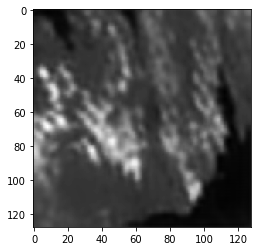

In [26]:
plt.imshow(out[0,0], cmap='gray')

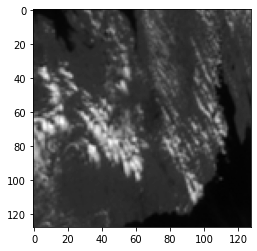

In [27]:
plt.imshow(true[0,0], cmap='gray')

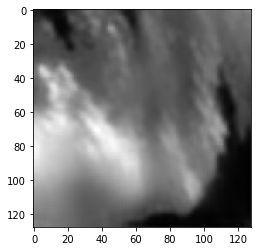

In [28]:
plt.imshow(out[0,-1], cmap='gray')

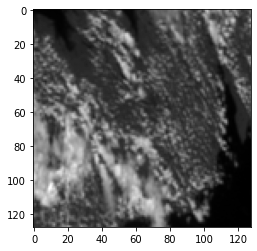

In [29]:
plt.imshow(true[0,-1], cmap='gray')